<a href="https://colab.research.google.com/github/Vibertexs/B-A-Tutorials/blob/main/Covid_Prediction_For_GitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the rate of COVID-19 transmission

In this notebook, we will build a machine learning model that will use hospitalization and infection data to predict the rate of COVID-19 transmission in the United States. If we can accurately predict future transmissions, we can help doctors and policymakers determine how to should allocate resources and craft interventions. In this notebook, we'll:


1.   Explore our data
2.   Use linear regression to predict future cases
3.   Use neural networks to predict future cases

![COVID map](https://upload.wikimedia.org/wikipedia/commons/f/f1/COVID-19_Prevalence_in_the_United_States_by_county.svg)



In [1]:
#@title Run this to prepare your data! { display-mode: "form" }

# source of data: https://www.kaggle.com/roche-data-science-coalition/uncover?

# Load the data!
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math
from math import sqrt
import random
import scipy
from scipy.interpolate import make_interp_spline

# see all columns and rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 40)
# set seed
random.seed(1)

import gdown 
gdown.download('https://drive.google.com/uc?id=1oK8AlCRFp4isBJQv-AZnC_zr-ZvrOOxd','covid-statistics-by-us-states-daily-updates.csv',True);

raw_data = pd.read_csv('covid-statistics-by-us-states-daily-updates.csv')

# turn date into datetime object
raw_data["date"] = pd.to_datetime(raw_data["date"], format="%Y-%m-%d")

raw_data.set_index("date", inplace = True, drop = False)

state_df_list = []
for name, df in raw_data.groupby("state"):
  tomorrow_data = df[['date','positiveincrease']]
  tomorrow_data.columns = ['tomorrow_date', 'tomorrow_new_pos']
  tomorrow_data['today_date'] = tomorrow_data.tomorrow_date - timedelta(days=1)
  tomorrow_data.set_index("today_date", inplace = True)
  state_df = df.join(tomorrow_data, how = 'inner')
  state_df_list.append(state_df)

data = pd.concat(state_df_list)
data.drop(['date','tomorrow_date'],axis=1,inplace=True)
data = data[~data.totaltestresultsincrease.isna()]
data = data[~data.total.isna()]
data = data[~data.positive.isna()]
data.negative = data.total - data.positive

data.sort_index(inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 1. Data exploration

### Filtering our data

Let's take a look at an example row from our data:

In [2]:
data.head()

,state,positive,negative,pending,hospitalizedcurrently,hospitalizedcumulative,inicucurrently,inicucumulative,onventilatorcurrently,onventilatorcumulative,recovered,hash,datechecked,death,hospitalized,total,totaltestresults,posneg,fips,deathincrease,hospitalizedincrease,negativeincrease,positiveincrease,totaltestresultsincrease,tomorrow_new_pos
2020-01-23,WA,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,faa0d0b985f479eac50082e417dc84f9e645db8f,2020-01-23 21:00:00,NaN,NaN,1.0,1.0,1.0,53,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,WA,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4763cdf13300976ba41317d7c7767e1c558a1134,2020-01-24 21:00:00,NaN,NaN,1.0,1.0,1.0,53,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,WA,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f17fc4cde1b2e7b57e946752d620e48d7f02c7ce,2020-01-25 21:00:00,NaN,NaN,1.0,1.0,1.0,53,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,WA,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,405aae8b4155c77878ab1e2a85f32d7bb7a45c9a,2020-01-26 21:00:00,NaN,NaN,1.0,1.0,1.0,53,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-27,WA,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15d0ad948df84d87c31ab25a4091a1980670fedd,2020-01-27 21:00:00,NaN,NaN,1.0,1.0,1.0,53,0.0,0.0,0.0,0.0,0.0,0.0


We only care about data that will help us predict rates of COVID-19. Right now, our data contains many unnecessary columns of information -- let's filter out unnecessary data.

We'll use each day's data to try to predict the number of positive test results the next day.

We want to include only the following columns: 

1. **"Date"**: the date for this row. This is already done for you - it's the index of the dataset - so you don't need to get this column)
2. **"State"**: the state that we're collecting COVID information about.
3. **"Positive"**: the total number of people who've tested positive for COVID up to today.
4. **"Negative"**:  the total number of people who've tested negative for COVID up to today.
5. **"Total"**: The total number of tests done up to today
6. **"Hospitalizedincrease"**: number of additional people who were hospitalized for conditions relating to COVID-19, compared to yesterday
7. **"Negativeincrease"**: Number of new negative tests today
8. **"Positiveincrease"**: Number of new positive tests today
9. **"Totaltestresultsincrease"**: Total number of new tests today
10. **"tomorrow_new_pos"**: Number of new positive results the next day. This is what we'll try to predict!

**NOTE**: The date column is automatically included in your data, so you don't need to worry about that column.


In [3]:
data.columns

Index(['state', 'positive', 'negative', 'pending', 'hospitalizedcurrently',
       'hospitalizedcumulative', 'inicucurrently', 'inicucumulative',
       'onventilatorcurrently', 'onventilatorcumulative', 'recovered', 'hash',
       'datechecked', 'death', 'hospitalized', 'total', 'totaltestresults',
       'posneg', 'fips', 'deathincrease', 'hospitalizedincrease',
       'negativeincrease', 'positiveincrease', 'totaltestresultsincrease',
       'tomorrow_new_pos'],
      dtype='object')

In [4]:

data = data[["state", "positive", "negative",
             "total", "hospitalizedincrease",
             "negativeincrease", "positiveincrease",
             "tomorrow_new_pos"]]



### Visualizing our data

Before we create our model, we need to understand our dataset and how we can use the data to answer our question. Let's take a look at our dataset!

In [5]:
data.head(15)

,state,positive,negative,total,hospitalizedincrease,negativeincrease,positiveincrease,tomorrow_new_pos
2020-01-23,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-01-24,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-01-25,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-01-26,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-01-27,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-01-28,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-01-29,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-01-30,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-01-31,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-02-01,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0


Try printing the number of **rows** and the number of **columns** in the dataset.

In [6]:
num_rows = data.shape[0]
num_columns = data.shape[1]

print (num_rows, "rows")
print (num_columns, "columns")

2915 rows
8 columns


Our overall goal is to create a model that can predict the number of new positive COVID-19 cases the next day. A good first step is to see how many positive COVID-19 cases each state has been having so far.


You've chosen to see the data for the state of DE


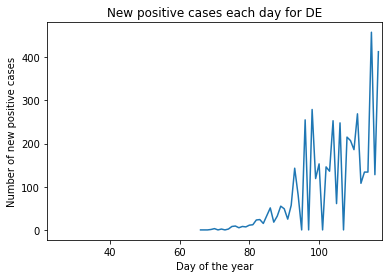

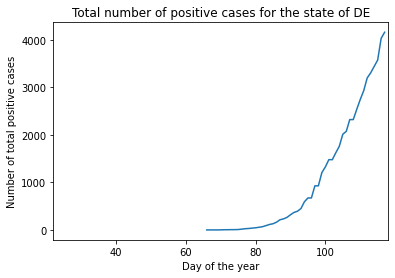

In [7]:
#@title ### Type in a state's two-letter abbreviation (e.g. CA for California) to see a graph of that state's positive COVID-19 cases over time. Try comparing the data for a few states!

# get state
state = "de" #@param {type:"string"}

# get uppercase version
state=state.upper()

# get states
states = set(data["state"])

# check to see if entry is in the state
if state not in states:
    raise ValueError("Abbreviation isn't a state. Please try again")
print(f"You've chosen to see the data for the state of {state}")


# check out graphs of positive cases, by week
new_data=data[data["state"] == state]
new_data.index = (new_data.index - datetime(2020, 1, 1)).days

plt.plot(new_data.index, new_data.tomorrow_new_pos)
plt.title(f"New positive cases each day for {state}")
plt.ylabel("Number of new positive cases")
plt.xlabel("Day of the year")
plt.xlim(22, 118)
plt.show()

plt.plot(new_data.index, new_data.positive)
plt.title(f"Total number of positive cases for the state of {state}")
plt.ylabel("Number of total positive cases")
plt.xlabel("Day of the year")
plt.xlim(22, 118)
plt.show()

## 2. Linear Regression

Now that we've done some exploratory analysis, we can start modeling. It's good practice to start with simpler models such as linear regression, see what patterns we can pick up on from creating these models, and then move on to more complex models such as neural networks.


### Review: What is linear regression?

**Linear regression** models the relationship between an **independent variable** `x` and a **dependent variable** `y` as a line:

$$y= mx + b$$



### Fitting a linear regression

Now that we have some idea of what a linear regression is, let's create one! We'll need to:

1. Prepare our data and perform a train-test split
2. Create and train our linear regression model
3. Make predictions using our model
4. Evaluate our model

First, we need to separate `X_raw` (our input: all the columns with today's data) from `y_raw` (our output: the number of positives tomorrow.) Create the data frames below using `data`:

In [8]:
X_raw = data.drop(['tomorrow_new_pos'],axis=1)

y_raw = data[["tomorrow_new_pos"]]

Now, let's handle a few data formatting issues: we'll convert the State column to one-hot-encoded columns and add a new day_of_year column.

In [9]:
#@title Run this to format data

# let's one-hot-encode our states
one_hot_columns = pd.get_dummies(X_raw.state, prefix="state")

# append one_hot_columns
X = pd.concat([X_raw, one_hot_columns], axis=1)
X.drop('state',axis=1,inplace=True)

X["day_of_year"] = (X.index - datetime(2020, 1, 1)).days

X.reset_index(inplace = True, drop=True)
y = y_raw.reset_index(drop = True)

X.head(5)

,positive,negative,total,hospitalizedincrease,negativeincrease,positiveincrease,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,day_of_year
0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22
1,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,23
2,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,24
3,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,25
4,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,26


#### 1. Perform a train-test split

Before we can create our model, we have to split our data into training and test data. **Why?**

Often, we split randomly. But today, we'll split by time: the first few months of our data will be the training data and the last few weeks will be testing data. **Question: Why split by time instead of randomly?**

It's to make sure that our model has never learned any information about the testing data. If we split randomly, we could have days in the testing data which are the "tomorrow" of a day in the training data!



Let's use an 80%/20% train-test split. Calculate the number of rows to use in training data:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
print(len(X_train))
print(len(X_test))

2332
583


#### 2. Create and train our linear regression model

Now, let's create our linear regression model! We'll use the linear regression model from Scikit-learn.


In [12]:
linear = linear_model.LinearRegression()

Next, let's train our linear regression model on our data.

In [13]:
linear.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


#### 3. Make predictions using our model

Now, let's make some predictions on the test set!



In [14]:
y_pred = linear.predict(X_test)

Remember how we're testing our model: we're giving the model true information about each day in the test set, and asking it to predict the number of positives the next day. How does it do?

You've chosen to see the data for the state of CA


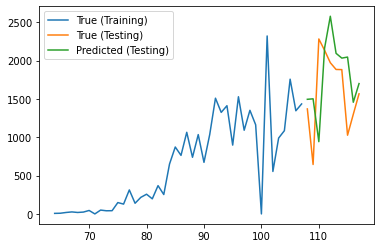

In [15]:
#@title ### Type in a state to check out our model's predictions

# get state
state = "ca" #@param {type:"string"}

def plot_true_and_pred(state, y_pred):
  # get uppercase version
  state=state.upper()

  # check to see if entry is in the state
  if state not in set(data["state"]):
      raise ValueError("Abbreviation isn't a state. Please try again")
  print(f"You've chosen to see the data for the state of {state}")

  y_pred_series = pd.Series(y_pred.squeeze(), index = y_test.index)

  X_train_state = X_train[X_train["state_"+state] == 1]
  X_test_state = X_test[X_test["state_"+state] == 1]

  early_true = y_train.loc[X_train_state.index]
  late_true = y_test.loc[X_test_state.index]
  late_pred = y_pred_series.loc[X_test_state.index]

  plt.plot(X_train_state.day_of_year, early_true)
  plt.plot(X_test_state.day_of_year, late_true)
  plt.plot(X_test_state.day_of_year, late_pred)
  plt.legend(["True (Training)", "True (Testing)", "Predicted (Testing)"])
  plt.show()

plot_true_and_pred(state, y_pred)


**Question**: How well is our model doing in different states? Does it tend to overestimate or underestimate? Do you notice other patterns?

Overall, our model seems to do well at predicting the number of cases *the next day*!

## 3. Neural Networks

We're doing pretty well with simple linear regression methods - but can we do even better?

Let's see if we can improve our MSE with a more complex model: Neural Networks.

![Neural Network](https://upload.wikimedia.org/wikipedia/commons/e/e4/Artificial_neural_network.svg)



Recall that a neural network consists of layers of interconnected "neurons", which learn to identify patterns in the input to make a prediction. For many tasks, like computer vision or speech recognition, neural networks far exceed other types of machine learning algorithms!

### Fitting a neural network

We will use `MLPRegressor`, which is a simple neural network model from Scikit-learn. We will experiment with the **number of neurons** and the **number of hidden layers** to improve the performance of our model!

**Example 1:**

If we want to create a neural network with 1 hidden layer and 4 neurons, we would say:

`nnet = MLPRegressor(hidden_layer_sizes=(4)) `

**Example 2:**

If we want to create a neural network with 2 hidden layers and 3 neurons in each layer:

`nnet = MLPRegressor(hidden_layer_sizes=(3, 3)) `

332679.45758942113
You've chosen to see the data for the state of WA


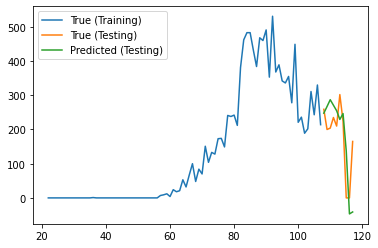

In [24]:
from sklearn.neural_network import MLPRegressor

# Creates the neural net
nnet = MLPRegressor(hidden_layer_sizes=(3,3),
                    activation="relu",
                    max_iter= 100000)

nnet.fit(X_train,y_train.values.ravel())

nnet_preds = nnet.predict(X_test)

error = mean_squared_error(y_test,nnet_preds)
print(error)

plot_true_and_pred("WA",nnet_preds)